## Project #3: Distributing COVID Vaccines: New Haven County
-------------------------------------------------------------------------

$Team$ $13-1:$ 
* Apurva Baddur (apb19015)
* Maria Santos  (mas14033)
* Monisha Jain  (moj19005)
* Yibo Li       (yil19059)


##Introduction

A vaccine for COVID-19 may become readily available for use in the U.S. over the next several months. At that point, government officials will begin to plan the costs associated with distributing the vaccine to various cities/towns across the nation. 

Although the U.S. has some experience with mass vaccine distribution, delivering said vaccines will need to be at much greater scale, which will bring new and unique challenges: cost. Thus, we are tasked to estimate the cost of shipping vaccines from hospitals to our 10 chosen towns from the New Haven county given that demand for vaccines is uncertain. 

## Objective 
* **Estimate the cost of shipping vaccines from hospitals to towns with uncertain demand by combining a minimum cost flow model with a monte carlo simulation.**


##Installing Modules and Setting up the Environment 


In [ ]:
#Mounting drive
from google.colab import drive
drive.mount('/content/drive')


#Import modules
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure


import numpy as np
import seaborn as sns # for plotting

%matplotlib inline
from pylab import *

import shutil
import sys
import os.path

if not shutil.which("pyomo"):
    !pip install -q pyomo
    assert(shutil.which("pyomo"))

if not (shutil.which("cbc") or os.path.isfile("cbc")):
    if "google.colab" in sys.modules:
        !apt-get install -y -qq coinor-cbc
    else:
        try:
            !conda install -c conda-forge coincbc 
        except:
            pass

assert(shutil.which("cbc") or os.path.isfile("cbc"))

from pyomo.environ import *
# ensure you have cbc installed
!apt-get install -y -qq coinor-cbc

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##Choosing our Ten Towns: EDA
* We have chosen our ten towns based on their respective population(s): 
  * The more individuals residing in said town, the more likely there would be more reported confirmed cases of COVID-19. We also observe that these are the 10 towns with the highest number of confirmed cases in New Haven county.
* Thus, we have chosen the following towns to include in our analysis: 

Town 			| Confirmed Cases
--- | ---
New Haven | 3330
Waterbury | 2903
Hamden    | 1238
Meriden   | 1231
West Haven | 1311
Milford   | 793
Wallingford | 685
Naugatuck | 685
Cheshire  | 337
East Haven | 497


### Loading the data




In [ ]:
#Read the data from csv file
from google.colab import files
uploaded = files.upload()

Saving New Haven County Spreadsheet - Sheet1.csv to New Haven County Spreadsheet - Sheet1 (1).csv


## Reading the File and Transforming it into a dataframe



In [ ]:
import pandas as pd 
import io

#Transforming file into pandas dataframe and saved it as "df"
towns = pd.read_csv('New Haven County Spreadsheet - Sheet1.csv')

#Snapshot of dataset
print(towns)


#Extract data we're interested in 
lat = towns['Y-Latitude'].values
lon = towns['X-Longitude'].values
population = towns['Population'].values
confirmedcases = towns['Confirmed Cases'].values


y_hos = 41.3044
x_hos = -72.9356


latitudes_y = ([41.7545445, 41.3363])
longitude_x = ([-72.6778707, -72.1046])





   Unnamed: 0         Town  ...  Population  Confirmed Cases
0           1    New Haven  ...      129779             3330
1           2    Waterbury  ...      110366             2903
2           3       Hamden  ...       60960             1238
3           4      Meriden  ...       60868             1231
4           5   West Haven  ...       55564             1311
5           6      Milford  ...       52759              793
6           7  Wallingford  ...       45135              685
7           8    Naugatuck  ...       31862              539
8           9     Cheshire  ...       29261              337
9          10   East Haven  ...       29257              497

[10 rows x 6 columns]


#Map of our 10 towns and Hospitals

In [ ]:
#Installing geopython libraries
%%time 

# Important library for many geopython libraries
!apt install gdal-bin python-gdal python3-gdal 
# Install rtree - Geopandas requirment
!apt install python3-rtree 
# Install Geopandas
!pip install git+git://github.com/geopandas/geopandas.git
# Install descartes - Geopandas requirment
!pip install descartes 
# Install Folium for Geographic data visualization
!pip install folium
# Install plotlyExpress
!pip install plotly_express




Reading package lists... Done
Building dependency tree       
Reading state information... Done
gdal-bin is already the newest version (2.2.3+dfsg-2).
python-gdal is already the newest version (2.2.3+dfsg-2).
python3-gdal is already the newest version (2.2.3+dfsg-2).
0 upgraded, 0 newly installed, 0 to remove and 14 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
python3-rtree is already the newest version (0.8.3+ds-1).
0 upgraded, 0 newly installed, 0 to remove and 14 not upgraded.
  Cloning git://github.com/geopandas/geopandas.git to /tmp/pip-req-build-ekfdgq_5
  Running command git clone -q git://github.com/geopandas/geopandas.git /tmp/pip-req-build-ekfdgq_5
  Created wheel for geopandas: filename=geopandas-0.8.0+70.gc325570-py2.py3-none-any.whl size=973052 sha256=22913cbf57ba3405ac1435dc4e468eaaf973c9c4c61a843616264a2a8140959a
  Stored in directory: /tmp/pip-ephem-wheel-cache-9fvvoife/wheels/91/24/71/376c9c67192694168352

In [ ]:
#Installing basemap from github
!apt-get install libgeos-3.5.0
!apt-get install libgeos-dev
!pip install https://github.com/matplotlib/basemap/archive/master.zip

Reading package lists... Done
Building dependency tree       
Reading state information... Done
E: Unable to locate package libgeos-3.5.0
E: Couldn't find any package by glob 'libgeos-3.5.0'
E: Couldn't find any package by regex 'libgeos-3.5.0'
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libgeos-dev is already the newest version (3.6.2-1build2).
0 upgraded, 0 newly installed, 0 to remove and 14 not upgraded.
  Using cached https://github.com/matplotlib/basemap/archive/master.zip
  Created wheel for basemap: filename=basemap-1.2.1-cp36-cp36m-linux_x86_64.whl size=121756179 sha256=cd6fad816f0a6fc6f75033c86292397152a87fc7b253bddeefa582c8d21093b7
  Stored in directory: /tmp/pip-ephem-wheel-cache-108zy0ht/wheels/98/4a/fc/ce719b75d97e646645c225f3332b1b217536100314922e9572
Successfully built basemap


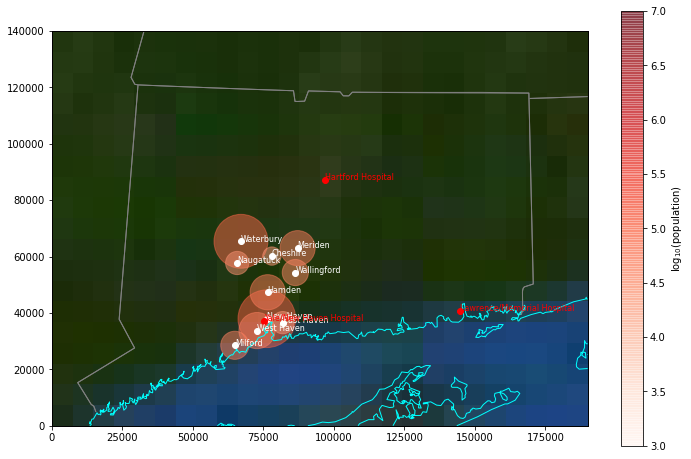

In [ ]:
#Set up map projections, scatter the data, and create a colorbar
from mpl_toolkits.basemap import Basemap
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12,8))
m = Basemap( projection='lcc', resolution='h', 
            lat_0=41.6, lon_0=-72.7,
            width=190000, height=1.4E5, suppress_ticks=False)


m.drawcoastlines(color='aqua')
m.drawcountries(linewidth=2.0, linestyle='solid',color='gray')
m.drawstates(linewidth=1.0, linestyle='solid',color='gray')
# draw parallels and meridians.
m.drawparallels(np.arange(-90.,91.,30.))
m.drawmeridians(np.arange(-180.,181.,60.))
m.bluemarble()


# 2. scatter city data, with color reflecting population
# and size reflecting confirmed cases
m.scatter(lon, lat, latlon=True,
          c=np.log10(population), s=confirmedcases,
          cmap='Reds', alpha=0.5)

# 3. create colorbar and legend
plt.colorbar(label=r'$\log_{10}({\rm population})$')
plt.clim(3, 7)

#Towns in CT
lon,lat =  m(lon,lat)
m.plot(lon,lat, 'wo')
plt.text(lon[0], lat[0], 'New Haven', fontsize=8,  color='white')
plt.text(lon[1], lat[1], 'Waterbury', fontsize=8,  color='white')
plt.text(lon[2], lat[2], 'Hamden', fontsize=8,  color='white')
plt.text(lon[3], lat[3], 'Meriden', fontsize=8,  color='white')
plt.text(lon[4], lat[4], 'West Haven', fontsize=8,  color='white')
plt.text(lon[5], lat[5], 'Milford', fontsize=8,  color='white')
plt.text(lon[6], lat[6], 'Wallingford', fontsize=8,  color='white')
plt.text(lon[7], lat[7], 'Naugatuck', fontsize=8,  color='white')
plt.text(lon[8], lat[8], 'Cheshire', fontsize=8,  color='white')
plt.text(lon[9], lat[9], 'East Haven', fontsize=8,  color='white')

#Hospitals in CT
x,y = m(x_hos, y_hos)
m.plot(x, y, 'ro')
plt.text(x, y, 'Yale/New Haven Hospital', fontsize=8,  color='red')

lonhos,lathos = m(longitude_x, latitudes_y)
m.plot(lonhos,lathos,'ro')
plt.text(lonhos[0],lathos[0], 'Hartford Hospital', fontsize=8,  color='red')
plt.text(lonhos[1],lathos[1], 'Lawrence/Memorial Hospital', fontsize=8,  color='red')

m.drawmapboundary(fill_color='aqua')

plt.show()

# Pairwise Distances

* We find the pairwise distances from 3 hospitals to 10 towns in New Haven County

In [ ]:
from sklearn.metrics.pairwise import haversine_distances
from math import radians


YaleNewHavenHospital = [41.3044, -72.9356]
HartfordHospital = [41.7545445,  -72.6778707]
GrotonLawrenceMemorialHospital = [41.3363, -72.1046]

NewHaven	= [41.311529,	-72.9248093]
Waterbury	= [41.55825942,	-73.03602135]
Hamden	= [41.39598579,	-72.92155498]
Meriden	= [41.53683838,	-72.79449399]
WestHaven	= [41.27365304,	-72.96647598]
Milford	= [41.2264013,	-73.06040522]
Wallingford	= [41.45905998,	-72.80415654]
Naugatuck	= [41.48897774,	-73.05176768]
Cheshire	= [41.51145185,	-72.9039953]
EastHaven	= [41.29913645,	-72.8573471]

YaleNewHavenHospital_in_radians = [radians(_) for _ in YaleNewHavenHospital]
HartfordHospital_in_radians = [radians(_) for _ in HartfordHospital]
GrotonLawrenceMemorialHospital_in_radians = [radians(_) for _ in GrotonLawrenceMemorialHospital]

NewHaven_in_radians = [radians(_) for _ in NewHaven]
Waterbury_in_radians = [radians(_) for _ in Waterbury]
Hamden_in_radians = [radians(_) for _ in Hamden]
Meriden_in_radians = [radians(_) for _ in Meriden]
WestHaven_in_radians = [radians(_) for _ in WestHaven]
Milford_in_radians = [radians(_) for _ in Milford]
Wallingford_in_radians = [radians(_) for _ in Wallingford]
Naugatuck_in_radians = [radians(_) for _ in Naugatuck]
Cheshire_in_radians = [radians(_) for _ in Cheshire]
EastHaven_in_radians = [radians(_) for _ in EastHaven]


## 1) Distance from Yale New Haven Hospital to our 10 Towns

In [ ]:

result_YNH = haversine_distances([YaleNewHavenHospital_in_radians, 
                              NewHaven_in_radians,
                              Waterbury_in_radians,
                              Hamden_in_radians,
                              Meriden_in_radians,
                              WestHaven_in_radians,
                              Milford_in_radians,
                              Wallingford_in_radians,
                              Naugatuck_in_radians,
                              Cheshire_in_radians,
                              EastHaven_in_radians])[0]
result_YNH * 6371000/1000  # multiply by Earth radius to get kilometers

array([ 0.        ,  1.2003111 , 29.4432081 , 10.25113503, 28.39798255,
        4.28297069, 13.56595053, 20.39648398, 22.69652688, 23.17350104,
        6.56296578])

##2) Distance from Hartford Hospital to our 10 towns

In [ ]:
result_HH = haversine_distances([HartfordHospital_in_radians, 
                              NewHaven_in_radians,
                              Waterbury_in_radians,
                              Hamden_in_radians,
                              Meriden_in_radians,
                              WestHaven_in_radians,
                              Milford_in_radians,
                              Wallingford_in_radians,
                              Naugatuck_in_radians,
                              Cheshire_in_radians,
                              EastHaven_in_radians])[0]
result_HH * 6371000/1000  # multiply by Earth radius to get kilometers

array([ 0.        , 53.37730473, 36.9013043 , 44.72690165, 26.07535332,
       58.62379884, 66.81328988, 34.49326308, 42.87112239, 32.92157404,
       52.79709025])

##3) Distance from Groton/Lawrence and Memorial Hospital to our 10 towns

In [ ]:
result_GLMH = haversine_distances([GrotonLawrenceMemorialHospital_in_radians, 
                              NewHaven_in_radians,
                              Waterbury_in_radians,
                              Hamden_in_radians,
                              Meriden_in_radians,
                              WestHaven_in_radians,
                              Milford_in_radians,
                              Wallingford_in_radians,
                              Naugatuck_in_radians,
                              Cheshire_in_radians,
                              EastHaven_in_radians])[0]
result_GLMH * 6371000/1000  # multiply by Earth radius to get kilometers

array([ 0.        , 68.54760241, 81.46027937, 68.49852382, 61.68213959,
       72.32875772, 80.79672785, 59.92625139, 80.78993052, 69.43879919,
       63.00044138])

# Network Graph

From 3 hospitals to 10 towns:

1) Yale New Haven Hospital to New Haven, Waterbury, Hamden, Meriden, West Haven, Milford, Wallingford, Naugatuck, Cheshire, East Haven

2) Hartford Hospital to New Haven, Waterbury, Hamden, Meriden, West Haven, Milford, Wallingford, Naugatuck, Cheshire, East Haven

3) Groton/Lawrence and Memorial Hospital to New Haven, Waterbury, Hamden, Meriden, West Haven, Milford, Wallingford, Naugatuck, Cheshire, East Haven


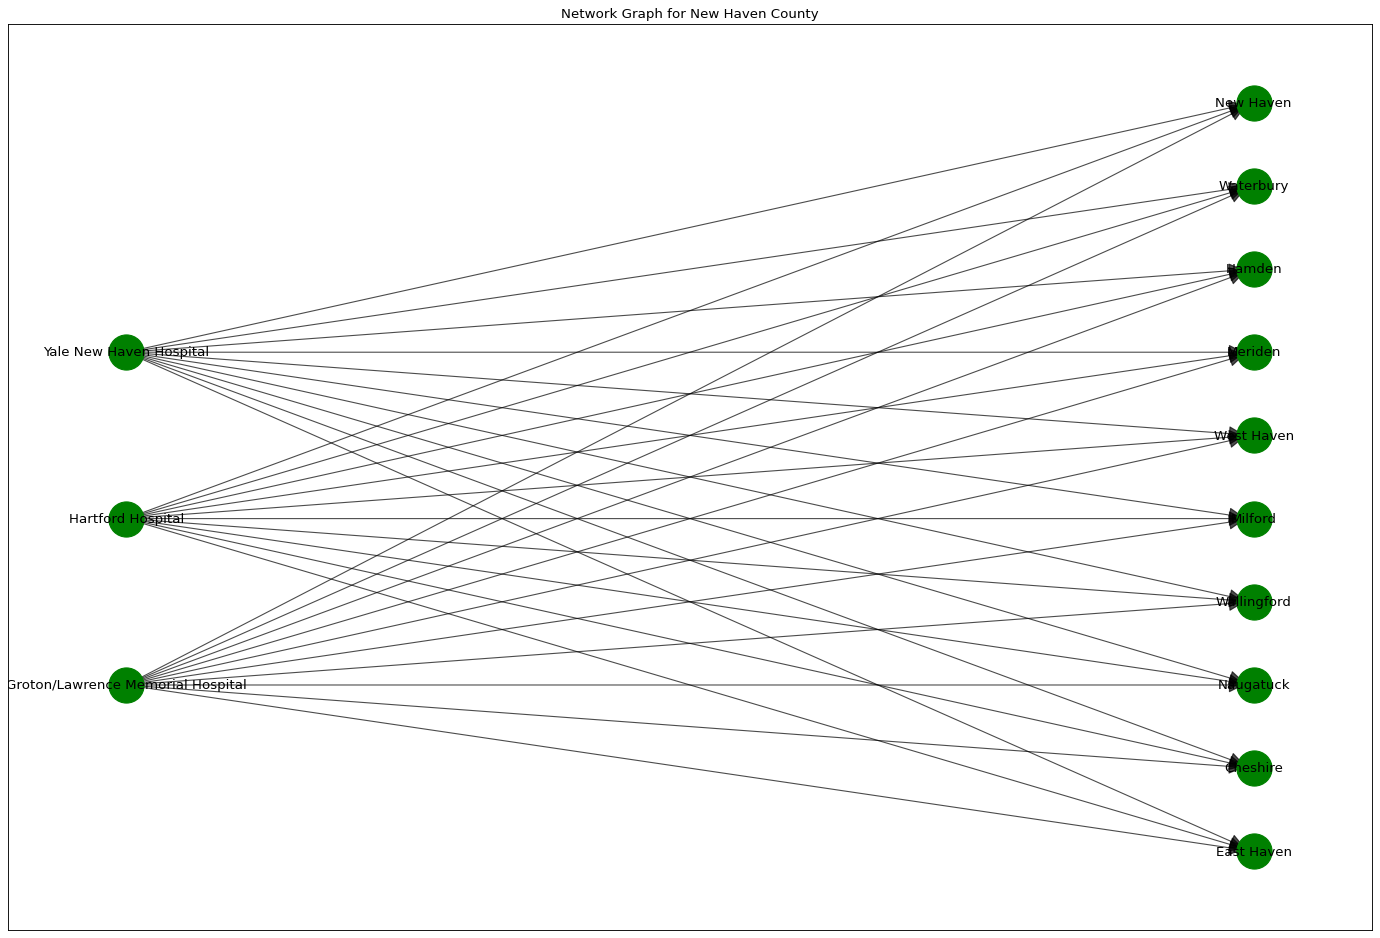

In [ ]:
# creating network model for New Haven county
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(num=None, figsize=(22, 15), dpi=80, facecolor='w', edgecolor='k')

G = nx.DiGraph()
G.add_edges_from(
    [('A', '1'),('A', '2'),('A', '3'),('A', '4'),('A', '5'),('A', '6'),('A', '7'),('A', '8'),('A', '9'),('A', '10'),
     ('B', '1'),('B', '2'),('B', '3'),('B', '4'),('B', '5'),('B', '6'),('B', '7'),('B', '8'),('B', '9'),('B', '10'),
     ('C', '1'),('C', '2'),('C', '3'),('C', '4'),('C', '5'),('C', '6'),('C', '7'),('C', '8'),('C', '9'),('C', '10'),])

#creating labels for 10 towns and 3 hospitals
labels = {'1':'New Haven', '2':'Waterbury', '3':'Hamden', '4':'Meriden','5':'West Haven', '6':'Milford', '7':'Wallingford', '8':'Naugatuck', '9':'Cheshire', '10':'East Haven','A':'Yale New Haven Hospital','B':'Hartford Hospital','C':'Groton/Lawrence Memorial Hospital'}

# Need to create a layout when doing
# separate calls to draw nodes and edges
fixed_positions = {'A':(1, 7),'B':(1, 5),'C':(1, 3) ,'1':(5, 10),'2':(5, 9),'3':(5, 8),'4':(5, 7), '5':(5,6), '6':(5,5), '7':(5,4), '8':(5,3), '9':(5,2), '10':(5,1)} 
fixed_nodes = fixed_positions.keys() 

pos = nx.spring_layout(G, k=2, pos=fixed_positions  ,fixed=fixed_nodes, iterations=100, threshold=0.0001, weight='weight', scale=1, center= [0,100], dim=2)
nx.draw_networkx_labels(G, pos, labels=labels)
nx.draw_networkx_nodes(G, pos=fixed_positions,  node_size = 1000, node_color= '#008000', )
nx.draw_networkx_edges(G, pos, arrows=True, arrowsize= 30, alpha=0.7, min_target_margin=5)
plt.title('Network Graph for New Haven County')
plt.show()

# Models 


## Model 1: Network Model (baseline/deterministic)

 * Nodes:
   * 1) Supply Nodes : 

      * Yale New Haven Hospital           (A)
      * Hartford Hospital                 (B)
      * Groton/Lawrence Memorial Hospital (C)
      
   * 2) Demand Nodes :

      * New Haven   (1) - 3330
      * Waterbury   (2) - 2903
      * Hamden      (3) - 1238
      * Meriden     (4) - 1231
      * West Haven  (5) - 1311
      * Milford     (6) - 793
      * Wallingford (7) - 685
      * Naugatuck   (8) - 539
      * Cheshire    (9) - 337
      * East Haven (10) - 497


The model has two types of constraints, greater than or equal to Supply constraints and equal to demand constraints

 * 1) Supply Constraints: At least 30% of the total demand (12,864) should be supplied by each hospital 
   * For Yale New Haven Hospital, we can express the constraint as follows:
    * A1 + A2 + A3 + A4 + A5 + A6 + A7 + A8 + A9 + A10 >= 12,864

   * Similarly, for Hartford Hospital and Groton/Lawrence Memorial Hospital, the constraints are as follows:
    * B1 + B2 + B3 + B4 + B5 + B6 + B7 + B8 + B9 + B10 >= 12,864
    * C1 + C2 + C3 + C4 + C5 + C6 + C7 + C8 + C9 + C10 >= 12,864

 * 2) Demand Constraints:
  * The demands for each of our 10 towns is as follows:
    * 1A + 1B + 1C = 3330
    * 2A + 2B + 2C = 2903
    * 3A + 3B + 3C = 1238
    * 4A + 4B + 4C = 1231
    * 5A + 5B + 5C = 1311
    * 6A + 6B + 6C = 793
    * 7A + 7B + 7C = 685
    * 8A + 8B + 8C = 539
    * 9A + 9B + 9C = 337
    * 10A + 10B + 10C = 497


   

### Objective Function and All Constraints
We put both kinds of constraints together, and build an objective function from the same set of variables and create the model



In [ ]:
import math

total_demand = towns['Confirmed Cases'].sum()

math.ceil(total_demand * 30/100)


# ------Demand Constraint

Demand = dict(zip(towns.Town, towns['Confirmed Cases']))

#-------Supply Constraint

Supply = { 'Yale New Haven Hospital': math.ceil(total_demand * 30/100), 'Hartford Hospital': math.ceil(total_demand * 30/100),
          'Groton/Lawrence Memorial Hospital': math.ceil(total_demand * 30/100)}


# -------Cost

#Creating dictionary for creating pairs of 3 hospitals with 10 towns  and their distances

Yale = {}
Hartford = {}
Gorton = {}
for i in range(len(towns)):
  Gorton[(towns['Town'][i],'Groton/Lawrence Memorial Hospital')] = result_GLMH[i+1] * 6371000/1000
  Hartford[(towns['Town'][i],'Hartford Hospital')] = result_HH[i+1] * 6371000/1000
  Yale[(towns['Town'][i],'Yale New Haven Hospital')] = result_YNH[i+1] * 6371000/1000

def Merge(dict1, dict2, dict3):
    res = {**dict1, **dict2,**dict3}
    return res

Cost = Merge(Yale, Hartford, Gorton)



In [ ]:
# Defining the model
# Step 0: Creating an instance of the model
model = ConcreteModel()

# Step 1: Defining index sets - dictionary syntax {key : value}
towns_ct = list(Demand.keys()) #demand
hospitals_ct = list(Supply.keys()) #supply

# Step 2: Defining the decision 
model.x = Var(towns_ct, hospitals_ct, domain = NonNegativeReals)

# Step 3: Defining Objective
model.Cost = Objective(
    expr = sum([Cost[t,h]*model.x[t,h] for t in towns_ct for h in hospitals_ct]),
    sense = minimize)

In [ ]:
# Step 4: Adding Constraints 
model.supplychannel = ConstraintList()
for h in hospitals_ct:
    model.supplychannel.add(sum([model.x[t,h] for t in towns_ct]) >= Supply[h])
        
model.demandchannel = ConstraintList()
for t in towns_ct:
    model.demandchannel.add(sum([model.x[t,h] for h in hospitals_ct]) == Demand[t])

In [ ]:
# solving the model
results = SolverFactory('cbc').solve(model)
results.write()

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 411401.7648
  Upper bound: 411401.7648
  Number of objectives: 1
  Number of constraints: 14
  Number of variables: 31
  Number of nonzeros: 30
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  User time: -1.0
  System time: 0.0
  Wallclock time: 0.0
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: None
      Number

In [ ]:
# printing the cost 
model.Cost()

411401.7647572388

In [ ]:
# printing the cost for each node
for t in towns_ct:
  for h in hospitals_ct:
    print(t, ',', h, ':', model.x[t,h]())

New Haven , Yale New Haven Hospital : 3330.0
New Haven , Hartford Hospital : 0.0
New Haven , Groton/Lawrence Memorial Hospital : 0.0
Waterbury , Yale New Haven Hospital : 0.0
Waterbury , Hartford Hospital : 2903.0
Waterbury , Groton/Lawrence Memorial Hospital : 0.0
Hamden , Yale New Haven Hospital : 0.0
Hamden , Hartford Hospital : 0.0
Hamden , Groton/Lawrence Memorial Hospital : 1238.0
Meriden , Yale New Haven Hospital : 0.0
Meriden , Hartford Hospital : 81.0
Meriden , Groton/Lawrence Memorial Hospital : 1150.0
West Haven , Yale New Haven Hospital : 1311.0
West Haven , Hartford Hospital : 0.0
West Haven , Groton/Lawrence Memorial Hospital : 0.0
Milford , Yale New Haven Hospital : 503.0
Milford , Hartford Hospital : 0.0
Milford , Groton/Lawrence Memorial Hospital : 290.0
Wallingford , Yale New Haven Hospital : 0.0
Wallingford , Hartford Hospital : 0.0
Wallingford , Groton/Lawrence Memorial Hospital : 685.0
Naugatuck , Yale New Haven Hospital : 0.0
Naugatuck , Hartford Hospital : 539.0


###Insights
* Based on our results, it is safe to assume that the government must allocate **$411,401.76** to distribute the vaccines to our respective towns.
* Surprisingly, a majority of the cities will be receiving a majority of the vaccines from both Yale New Haven Hospital and Groton/Lawrence Memorial Hospital. 



## Model 2: Monte Carlo Simulation and Network Model

In this model, we will be running the model 10k times by taking a sample of 10k from demand distribution. In this model, Our hospitals will supply at least 30% of the total demand of our 10 towns.
Here, Demand at each town follow a triangle distribution where minimum is the current demand, maximum demand is 5 times of the current demand and mode is 2 times of the current demand.
The Shipping cost from one hospital to each town would remain same as the distance between each hospital and town won't change.

In [ ]:
# Running the model 10k times by taking a sample of 10 k from demand distribution
resultsDF_10 = []

for b in np.arange(10000):
  

# Demand 

  Demand_tri = {}

  for i in Demand.keys(): # demand for all the towns generated and stored in a dictionary by a for loop
    Demand_tri[i] = int(np.random.triangular(Demand[i], Demand[i] * 2 , Demand[i]* 5, size = 1)) 
  Demand_tri 

  total_demand_tri = sum(list(Demand_tri.values())) # total demand calculated by adding all the values from the above made dictionary

# Supply

  Supply = { 'Yale New Haven Hospital': math.ceil(total_demand_tri * 30/100), 'Hartford Hospital': math.ceil(total_demand_tri * 30/100),
          'Groton/Lawrence Memorial Hospital': math.ceil(total_demand_tri * 30/100)}          

# Cost

  Yale = {}
  Hartford = {}
  Gorton = {}
  for i in range(len(towns)):
    Gorton[(towns['Town'][i],'Groton/Lawrence Memorial Hospital')] = result_GLMH[i+1] * 6371000/1000
    Hartford[(towns['Town'][i],'Hartford Hospital')] = result_HH[i+1] * 6371000/1000
    Yale[(towns['Town'][i],'Yale New Haven Hospital')] = result_YNH[i+1] * 6371000/1000

  def Merge(dict1, dict2, dict3):
      res = {**dict1, **dict2,**dict3}
      return res

  Cost = Merge(Yale, Hartford, Gorton)
  model1 = ConcreteModel()

# Step 1: Defining index sets - dictionary syntax {key : value}
  towns_ct = list(Demand_tri.keys()) #demand
  hospitals_ct = list(Supply.keys()) #supply

# Step 2: Defining the decision 
  model1.x = Var(towns_ct, hospitals_ct, domain = NonNegativeReals)

# Step 3: Defining Objective
  model1.Cost = Objective(
      expr = sum([Cost[t,h]*model1.x[t,h] for t in towns_ct for h in hospitals_ct]),
      sense = minimize)
# Step 4: Adding Constraints 
  model1.supplychannel = ConstraintList()
  for h in hospitals_ct:
      model1.supplychannel.add(sum([model1.x[t,h] for t in towns_ct]) >= Supply[h])
        
  model1.demandchannel = ConstraintList()
  for t in towns_ct:
      model1.demandchannel.add(sum([model1.x[t,h] for h in hospitals_ct]) == Demand_tri[t])
# solving the model
  results = SolverFactory('cbc').solve(model1)
  results.write()


  resultsDF_10 = np.append(resultsDF_10, model1.Cost())
  resultsDF_15 = np.append(resultsDF_10, total_demand_tri)
  # print('Results:', results)

# out of the loop - no tab here!
print('IM DONE!')
  
  
    

Streaming output truncated to the last 5000 lines.
  Time: 0.03795933723449707
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of solutions displayed: 0
# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 1088745.276
  Upper bound: 1088745.276
  Number of objectives: 1
  Number of constraints: 14
  Number of variables: 31
  Number of nonzeros: 30
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Us

In [ ]:
# Shipping cost at the end of each iteration 
print(resultsDF_10.shape) 
resultsDF_10

(10000,)


array([ 814366.8282505 , 1193553.26762094, 1428470.94000495, ...,
       1007013.06477236,  991389.6328685 ,  849879.96899614])

In [ ]:
# Mean of the distribution of the Shipping cost
np.mean(resultsDF_10)

1105403.2252248446

In [ ]:
#Mean of the distribution of the demand for model 2.1
np.mean(resultsDF_15)

1105295.4371811263

## Model 2 (Pt.2)

In this model, we will be running the model 10k times by taking a sample of 10k from demand distribution. In this model, Our hospitals will supply at least 10% of the total demand of our 10 towns. 

Here, Demand at each town follow a triangle distribution where minimum is the current demand, maximum demand is 5 times of the current demand and mode is 2 times of the current demand. 

The Shipping cost from one hospital to each town would remain same as the distance between each hospital and town won't change.  

In [ ]:
# Running the model 10k times by taking a sample of 10 k from demand distribution 
resultsDF_20 = []

for b in np.arange(10000):
  

# Demand 

  Demand_tri = {}

  for i in Demand.keys(): # demand for all the towns generated and stored in a dictionary by a for loop
    Demand_tri[i] = int(np.random.triangular(Demand[i], Demand[i] * 2 , Demand[i]* 5, size = 1)) 
  Demand_tri 
  total_demand_tri = sum(list(Demand_tri.values())) # total demand calculated by adding all the values from the above made dictionary

# Supply

  Supply = { 'Yale New Haven Hospital': math.ceil(total_demand_tri * 10/100), 'Hartford Hospital': math.ceil(total_demand_tri * 10/100),
          'Groton/Lawrence Memorial Hospital': math.ceil(total_demand_tri * 10/100)}          

# Cost

  Yale = {}
  Hartford = {}
  Gorton = {}
  for i in range(len(towns)):
    Gorton[(towns['Town'][i],'Groton/Lawrence Memorial Hospital')] = result_GLMH[i+1] * 6371000/1000
    Hartford[(towns['Town'][i],'Hartford Hospital')] = result_HH[i+1] * 6371000/1000
    Yale[(towns['Town'][i],'Yale New Haven Hospital')] = result_YNH[i+1] * 6371000/1000

  def Merge(dict1, dict2, dict3):
      res = {**dict1, **dict2,**dict3}
      return res

  Cost = Merge(Yale, Hartford, Gorton)
  model3 = ConcreteModel()

# Step 1: Defining index sets - dictionary syntax {key : value}
  towns_ct = list(Demand_tri.keys()) #demand
  hospitals_ct = list(Supply.keys()) #supply

# Step 2: Defining the decision 
  model3.x = Var(towns_ct, hospitals_ct, domain = NonNegativeReals)

# Step 3: Defining Objective
  model3.Cost = Objective(
      expr = sum([Cost[t,h]*model3.x[t,h] for t in towns_ct for h in hospitals_ct]),
      sense = minimize)
# Step 4: Adding Constraints 
  model3.supplychannel = ConstraintList()
  for h in hospitals_ct:
      model3.supplychannel.add(sum([model3.x[t,h] for t in towns_ct]) >= Supply[h])
        
  model3.demandchannel = ConstraintList()
  for t in towns_ct:
      model3.demandchannel.add(sum([model3.x[t,h] for h in hospitals_ct]) == Demand_tri[t])
# solving the model
  results = SolverFactory('cbc').solve(model3)
  results.write()


  resultsDF_20 = np.append(resultsDF_20, model3.Cost())
  resultsDF_25 = np.append(resultsDF_20, total_demand_tri)
  # print('Results:', results)

# out of the loop - no tab here!
print('IM DONE!')
  
  
    

Streaming output truncated to the last 5000 lines.
  Time: 0.031126022338867188
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of solutions displayed: 0
# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 488929.0749
  Upper bound: 488929.0749
  Number of objectives: 1
  Number of constraints: 14
  Number of variables: 31
  Number of nonzeros: 30
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  U

In [ ]:
# Shipping cost at the end of each iteration
print(resultsDF_20.shape) 
resultsDF_20

(10000,)


array([803942.99656067, 654373.49583222, 533471.61887582, ...,
       555178.39958839, 637035.65940123, 499161.26261278])

In [ ]:
# Mean of the distribution of the Shipping cost
np.mean(resultsDF_20)

644206.2772072525

In [ ]:
#Mean of distribution of  demand for model 2.2
np.mean(resultsDF_25) 

644144.519355317

## Analysis

###Model 2 (Pt.1)

Model in which supply is at least 30% of total demand by each hospital



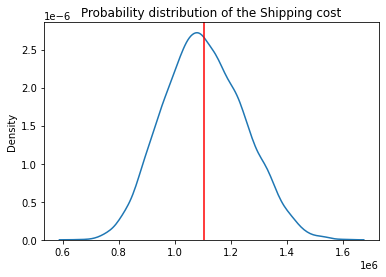

In [ ]:
# Distribution of the Shipping cost
sns.kdeplot(resultsDF_10)
plt.axvline(np.mean(resultsDF_10), color='red')
plt.title('Probability distribution of the Shipping cost')
plt.show() # gets rid of unneeded text

##Insights 
* Based on the aforementioned results, we expect the shipping costs to fall near $1,105,403.22$ dollars. 
* Surprisingly, we can see that the distribution of said plot follows a normal distribution. 
* The likelihood that the shipping costs fall within the  $1.4 - 1.6$ million range is 0.005. 

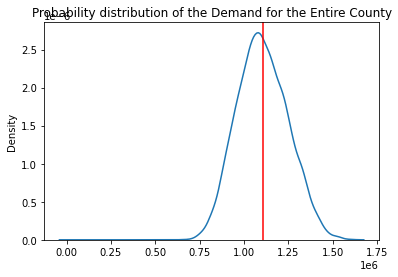

In [ ]:
# Distribution of the Demand
sns.kdeplot(data=resultsDF_15)
plt.axvline(np.mean(resultsDF_15), color='red')
plt.title('Probability distribution of the Demand for the Entire County')
plt.show() # gets rid of unneeded text

##Insights 
* The graph highlights that the demand distribution for our given county is right-skewed. 
* We expect that the demand for said county will fall at approximately $1,105,295.43$ cases. 



### Model 2 (Pt. 2)

Model in which supply is atleast 10% of total demand by each hospital

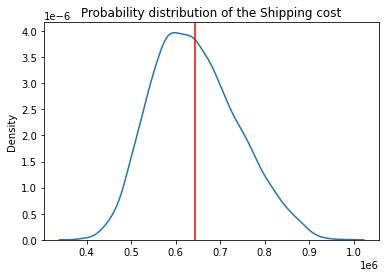

In [ ]:
# Distribution of the Shipping cost
sns.kdeplot(resultsDF_20)
plt.axvline(np.mean(resultsDF_20), color='red')
plt.title('Probability distribution of the Shipping cost')
plt.show() # gets rid of unneeded text

##Insights 
* Based on the aforementioned results, we expect that the shipping costs (given the change of supply for vaccines) will fall near $644,206.27. 
  * This is significantly less expensive compared to our previous results 
* Moreover, the distribution of the graph is slightly right-leaning 

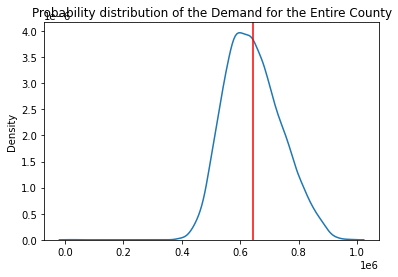

In [ ]:
# Distribution of the Demand 
sns.kdeplot(data=resultsDF_25)
plt.axvline(np.mean(resultsDF_25), color='red')
plt.title('Probability distribution of the Demand for the Entire County')
plt.show() # gets rid of unneeded text

##Insights 
* We expect that the demand for our given county will fall near 644,144.cases. 
* Moreover, the graph indicates that that distribution is left-skewed. 


#Conclusion 
* Based on our results, we recommend the government allocating at least $644,206.27$ dollars to account for shipping expenses. 
  * If we were to compare the shipping expenses from both models (not including the baseline/deterministic model), the government saves a little over $440,000.00$ dollars.
  * Luckily, covid cases aren't increasing exponentially, reducing the need for hospitals to cover a large percentage of vaccines to our given county.
* Interestingly enough, both Yale New Haven Hospital and Groton/Lawrence Memorial Hospital supplied a majority of the cities in our county with the necessary vaccines.
  * This makes sense as Hartford Hospital is farther away from our 10 citiies (compared to the other two hospitals).
* Now, if the government wants to be 90% sure that they can cover shipping expenses, we recommend them allocating at least $800,000$ dollars (which still is inexpensive compared to our original assumption illustrated in Model2.1). 
* In the future, though, we'd like to at least focus on potentially decreasing the run-time of both Model(s) 2.1 and 2.2. 
  * This will allow us to simulate more scenarios if need be for a fraction of the time! 

## Team Contributon

* Apurva Baddur: Completed a majority of the EDA portion of our project - 10/10
* Maria Santos - Generated insights for each individual model and completed the conclusion - 10/10
* Monisha Jain - Constructed a majority of the models - 10/10
* Yibo Li - Constructed Model 2.1 - 10/10

